# T2 - Calibration

Models are simplifications of the real world, and quantities in the model (like the force of infection) represent the aggregation of many different factors. As a result, there can be uncertainty as to what value of the parameters most accurately reflects the real world - for instance, the population force of infection varies with the average number of contacts per person per day, but this quantity may not be well constrained. The first step in running a model is to improve estimates of the parameter values for a particular setting, using data from that setting. Typically, the model is started off at some point in the past (e.g. 2000), such that the initial compartment sizes correspond to the data in the simulation start year. The model is then run up to the current year, with the compartment sizes changing due to the model parameters. The model predictions can then be compared to the actual data for those same years. This allows model parameters to be adjusted to best match the existing data. These same parameters are then used for future projections.

To see calibration in effect, consider the following simple example:

In [1]:
import atomica as at
P = at.Project(framework='assets/T2/t2_framework_1.xlsx',databook='assets/T2/t2_databook_1.xlsx', do_run=False)

First, we inspect the default calibration by running the model and plotting it along with the data. To plot the data, pass the project's data to the plotting function (in this case, `plot_series`) - this will automatically add scatter points to the plot based on the data in the databook.

Elapsed time for running "default": 0.0132s


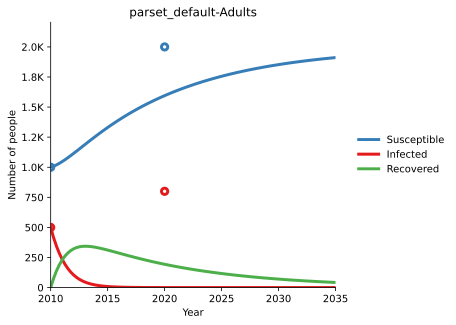

In [2]:
result = P.run_sim()
d = at.PlotData(result,project=P)
at.plot_series(d, data=P.data);

Notice how the number of susceptible people and infected people exactly match the data points in the simulation start year - as noted above, this is because the model is initialized from the data values in that year. There are some conditions under which the model won't exactly match the data in the initial year, such as if the initialization characteristics are overdetermined, but these situations are rare. 

We can see, however, that the model does not predict enough susceptible people in 2020. There could be many reasons for this, and determining what parts of the model should be changed can often be something of an art. It typically reflects your understanding of the assumptions that were made in designing the framework, and also uncertainties and bias present in the input data. For example, the methodology used to gather data used for the calibration might provide hints as to which parameters to change first.

In this case, as there are insufficient people, it might be the case that the birth rate was too low. There are two ways to address this

- You could go back to the databook and enter a larger value for the birth rate
- You can add a 'scale factor' to the parameter set, which scales the parameter value up or down

Either approach can be used and would provide equivalent results. Why would we prefer one over the other?

<table>
<thead>
<tr><th>Decision factor</th><th> Databook calibration </th><th> Scale factor calibration</th></tr>
</thead>
<tbody>
<tr><td>How do you want to adjust the parameter? </td><td> Manual adjustment </td><td> Automatic adjustment</td></tr>
<tr><td>What kinds of parameters is this appropriate for?</td><td> Appropriate for model assumptions </td><td> Appropriate for original data</td></tr>
<tr><td>Granularity of calibration? </td><td> Adjustments can vary by year or even timestep </td><td> Single scaling factor for all timesteps</td></tr>
<tr><td>Pros?</td><td> 
<ul>
<li>Easy to review reference point for value used in project</li>
<li>What you see is what you get in the databook</li>
</ul>
</td>
<td> 
<ul>
<li>Maintains scatter points on plots of the parameter</li>
<li>Can calibrate a parameter with a function without defining additional multiplicative parameters</li>
</ul>
</td>
<tr><td>Cons?</td><td> Can cause confusion in the databook around what is data and what is not data</td><td> Can lack transparency about how parameters are being adjusted without careful review</td></tr>
</tbody>
</table>
    
An example of a suitable parameter for databook calibration is `relative seasonality of mosquito population size` - no hard data can exist, but it might be possible to calculate proxy values from other data such as rainfall patterns in different years, adjust annual values manually to match historical epidemic patterns, and then assume a median value for future years. Having this assumption in the databook allows for those calculations to be used as a starting point in the databook before manually editing, and allows for comparability with other projects that use the same parameter. 

<div class="alert alert-block alert-success">
<b>Suggestion:</b> When designing a databook, it is recommended that <b>all</b> parameters intended for explicit databook calibration are placed on a single 'Calibration' sheet to provide clarity about what is data and what are calibrated assumptions.
</div>

An example of a suitable parameter for scale factor calibration is `treatment initiation` used to determine model transitions from diagnosed to treated - a country has reported data for the number of people initiating treatment, and it is important to accurately maintain the official numbers in the databook. Nevertheless, there may be systematic under-reporting by an unknown degree and we want to account for those additional treatments in the model to ensure outcomes are representative, so it is appropriate to adjust the scale factor.

An example of a parameter that could be adjusted in either way depending on the circumstances or just personal preference would be `force of infection` - this is a clear calibration parameter that is not based on data, and could be adjusted in a databook if it's necessary to reflect changing circumstances external to the model over time, calibrated automatically with a scale factor via the `calibrate` function below in order to achieve the best fit to data, or even a mixture of the two methods.


<div class="alert alert-block alert-info">
The web interfaces (such as the Cascade Analysis Tool) perform calibration using scale factors. The scale factors shown on the website correspond to the values being set here.
</div>

To set a scale factor, create a `ParameterSet` either by copying an existing one, or creating a new one. Then, access the `pars` attribute to look up the parameter you wish to change, and set the `y_factor` for the population you want to change:

In [3]:
p2 = P.parsets[0].copy()
p2.pars['b_rate'].y_factor['adults'] = 2

The example above doubled the birth rate. Now we can run the model again, and see how the results have changed. Notice how the `PlotData` command is being called with both the original results object, and the new results object, allowing both model runs to be shown on the same plot.

Elapsed time for running "default": 0.0138s


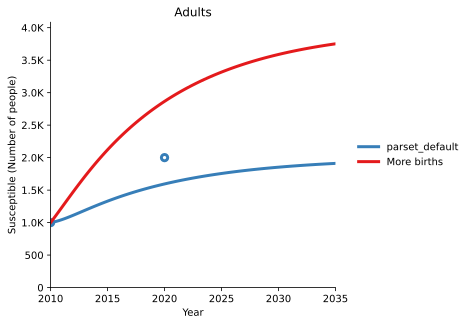

In [4]:
r2 = P.run_sim(parset=p2,result_name = 'More births')
d = at.PlotData([result,r2], outputs='sus',project=P)
at.plot_series(d,axis='results',data=P.data);

We can see that we have considerably overshot the data, indicating that doubling the birth rate was much too big a change. This would typically be the first step in an iterative process, where you adjust the scale factor, inspect the data, and then make further adjustments. 

Automated calibration is also available via the project's `calibrate` method. This will automatically adjust parameter values to match the data. To use this function, you need to specify which parameters to set scale factors for, and which variables in the databook to compute calibration quality from. The framework can provide defaults for which parameters to automatically calibrate, or you can pass a list of those parameters in directly. In this example, we will pass in `b_rate` because we want to adjust the birth rate, and we will use `sus` as a measurable since we want to match the number of susceptible people. The configuration therefore corresponds to the example shown above. 

In [5]:
with at.Quiet():
    p3 = P.calibrate(max_time=10, parset='default', adjustables=['b_rate'], measurables=['sus']);

The result of automated calibration is another `ParameterSet`. We can inspect the scale factor that the algorithm found:

In [6]:
p3.pars['b_rate'].y_factor

#0: 'adults': 1.318720293045044


and we can run the model to compare the automated calibration to the original default calibration:

Elapsed time for running "default": 0.0135s


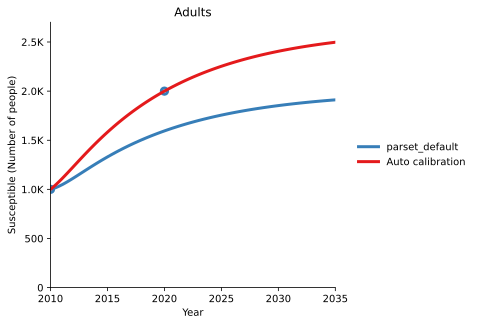

In [7]:
r3 = P.run_sim(parset=p3,result_name = 'Auto calibration')
d = at.PlotData([result,r3], outputs='sus',project=P)
at.plot_series(d,axis='results',data=P.data);

## Calibration tips

While calibrations can vary significantly from model-to-model, it's generally a good idea to try and match coarse-grained quantities first, followed by fine-grained quantities. For example, for TB you might calibrate it in the following order:

1. Match population size (adjusting birth rate and death rate)
2. Match disease prevalance (adjusting force of infection)
3. Match drug-resistant/drug-susceptible split (adjusting proportion of infections that are drug-resistant)
    
For complex models when considering how to proceed with a calibration, it can help to start with mapping the expected relationships between key input parameters that will be used for calibration and key output parameters for which data exists and that should be matched by the calibration, in terms of how changes might flow throughout the model.

![t2-calibration-mapping.png](images/t2_calibration_mapping.png)

From the diagram above, it can be seen that as is typically the case, population size (`alive`) has a large impact on everything else, but the number of disease-related deaths have only a minor impact on population size in return, so population size needs to be matched first. Incidence (`inci`) and prevalence (`inf`) have a strong cyclical relationship should be considered together, but force of infection and recovery rate have direct links to modifying each of those individually through changing the rate at which people are infected and changing the rate at which people recover. Disease-related deaths (`m_num`) can be considered last if it is not already closely matched from calibrating to prevalence. Because this may adjust the population size, an iterative cycle of calibration may be appropriate to get the best overall fit.

A calibration might then proceed in the following order with three repeats:

In [8]:
cal_par = P.parsets['default'].copy()
with at.Quiet():
    for _ in range(3):
        cal_par = P.calibrate(max_time=10, parset=cal_par, adjustables=['b_rate', 'doth_rate'], measurables=['alive'])
        cal_par = P.calibrate(max_time=10, parset=cal_par, adjustables=['foi', 'rec_rate'], measurables=['inci', 'inf'])
        cal_par = P.calibrate(max_time=10, parset=cal_par, adjustables=['m_rate'], measurables=['m_num'])

Elapsed time for running "default": 0.0105s


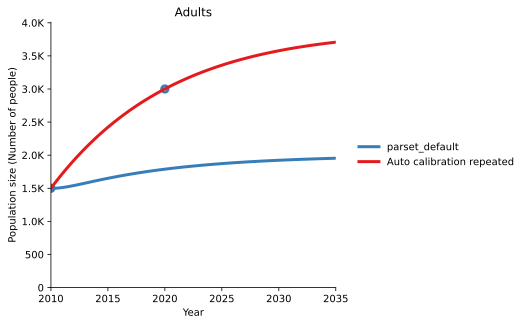

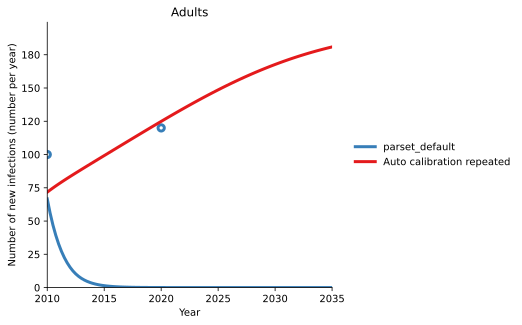

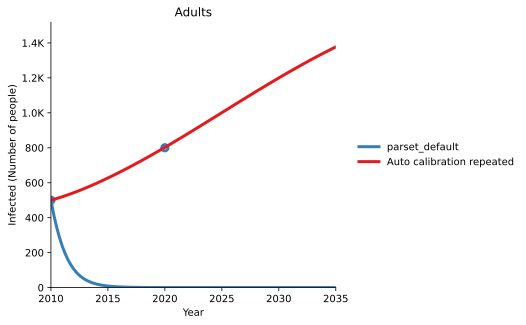

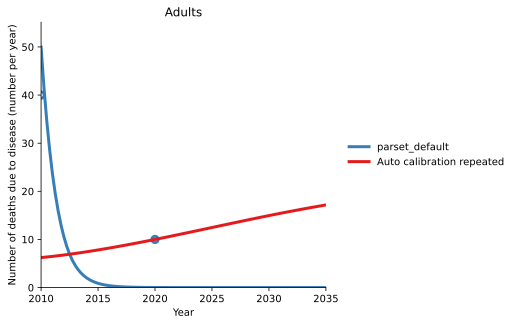

In [9]:
r4 = P.run_sim(parset=cal_par,result_name = 'Auto calibration repeated')
for output in ['alive', 'inci', 'inf', 'm_num']:
    d = at.PlotData([result,r4], outputs=output,project=P)
    at.plot_series(d,axis='results',data=P.data);

There are a few major dangers in calibration, including but not limited to:

**1. Solution-rich spaces**

Often multiple input parameters can be adjusted and they might superficially produce the same historical trend lines. For example if modelled prevalence is far lower than data points from epidemiological surveys, a better calibration might be achieved in a number of different ways: increased force of infection (calibration parameter), increased behavioural risk factors (e.g. number of shared injections for HIV), increased duration of infection, reduced treatment success rate, or any number of other subtle data inputs. Where possible calibrate to include data from multiple other outputs, and even if this is not possible _review_ other outputs as a sanity check. In addition, consult country experts to determine which solution better explains the trend where it is not clear from the data.

**2. Overfitting**

Don't try to exactly match every historical data point such as by adjusting 'force of infection' precisely for every historical year. Often there is year to year variation in diagnostic capacity, reporting, or natural fluctation based on behaviour or external circumstances. It is more important to accurately capture the trend and the _reasons_ for that trend in the model than to match data from every year exactly, and this will lead to more reasonable future projections as well as a more useful model for prioritizing programs.

**3. Inaccurate data**

In conjunction with overfitting - not all data is of equal quality or reliability, or it may have been gathered with a methodology that does not exactly fit the way it is used in the model (*this is often a good argument to adjust the model if it applies to more than a single project*). Be aware of the quality of data and prioritize calibration to data that is known to be more accurate in a given project. Sometimes it is better to just ignore data for a specific output parameter if the methodology used to gather that data was unreliable or cannot be adequately represented by the model.

**4. Forced outcomes**

Especially with automatic calibration, it is possible to match outputs with some extreme values for `y_factor`. Some examples of how this can occur:
- The calibration of `prev` in a Males 50+ population using the `foi` parameter results in a `y_factor` of 0.00001 - if optimizations are run with this force of infection value, the Males 50+ population will be almost immune to infection for any reason, and any programs that target Males 50+ will be defunded. In reality, something else is wrong in the model, perhaps this high prevalence is because of Males 40-49 aging into the 50+ population and that population should be reviewed, or even more likely there is a risk-based transition from a key population such as people who inject drugs which is too high.
- The calibration to match `incidence` in children aged 0-14 using the `foi` parameter results in a `y_factor` of 1000. The real reason for this may be that the model itself has failed to include the critical pathway for child incidence through mother-to-child transmission.

In order to avoid these kinds of modelling outcomes it is critical to (a) review calibration values/`y_factors` to ensure they are within expected bounds, and (b) if there are extreme values conduct further investigation, as there will be something else that should be changed to improve how the model represents reality, and this will result in better recommendations using the model.

In [10]:
for par in ['b_rate', 'doth_rate', 'foi', 'rec_rate', 'm_rate']:
    print (f'{par}: y_factor = {cal_par.pars[par].y_factor["adults"]}')

b_rate: y_factor = 1.837382737140886
doth_rate: y_factor = 0.8932264965978538
foi: y_factor = 1.0755615234375
rec_rate: y_factor = 0.008870220716198675
m_rate: y_factor = 0.12463647633233842


Some of these values are low at around 0.15, and this can be attributed to the high value for prevalence (`inf`) in the databook requiring a low value for each of `doth_rate`, `rec_rate`, and `m_rate`. Individually these are not outside of a 'reasonable' range for calibration `y_factors` but as they are all needed to fit a single data point this might suggest a second look at the reliability of original data values for prevalence in this project.

**5. Missing model features**
Calibration at its best accounts for factors outside of a model in order to focus on what is in the model. Sometimes those factors have too big an impact on the model to be ignored, and the right solution is to add depth to the model as the only other solution is to force outcomes with extreme `y_factors` or unrealistic values for other parameters.

In the example above, it is impossible to match both the 2010 and 2020 data points for number of deaths (`m_num`) as they are not consistent with increasing prevalence. Perhaps it is necessary to calibrate a changing `m_rate` over time in the databook, or even add diagnosis and treatment to the model?

**6. 'Burn-in' period**
Often with more complex models, there may be too many parameters to initialize each and every one of them accurately in the first time step of the model via databook entry, such as tracking compartments for many different stages of a disease or stages of treatment. In these cases, it may be best to initialize just using key databook values such as 'number on treatment', 'number infected' and make assumptions for compartments within these categories. This will typically result in strange model behaviour for a number of time steps during a 'burn-in' period before the proportions at different stages of treatment settle down to an equilibrium, so it may be necessary to exclude these burn-in years from exported results in general, and not try to match these in calibration. Ideally, the model should either initialize a model earlier (e.g. several years in models with long time steps) and/or  calibrate to the years for which data exists, and exclude those burn-in years from exported results in general.